In [2]:
import sys
import os
from openai import OpenAI

# Use current working directory and go one level up
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# Now you can import your config
from config import api_key

client = OpenAI(api_key=api_key)

In [10]:
# Import required libraries
import os
import openai
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import chromadb
from scipy.spatial import distance
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Initialize your API key
openai_api_key = api_key

#EMBEDDING_MODEL = "text-embedding-ada-002"
EMBEDDING_MODEL = "text-embedding-3-small"

# Load the dataset
reviews = pd.read_csv("Womens Clothing E-Commerce Reviews.csv").sample(n=1000, random_state=54)
review_texts = reviews["Review Text"].dropna()

# Create and store the embeddings for reviews in one API call
client = openai.OpenAI(api_key=openai_api_key)
responses = client.embeddings.create(input=review_texts.tolist(), model=EMBEDDING_MODEL).model_dump()
embeddings = [response["embedding"] for response in responses["data"]]

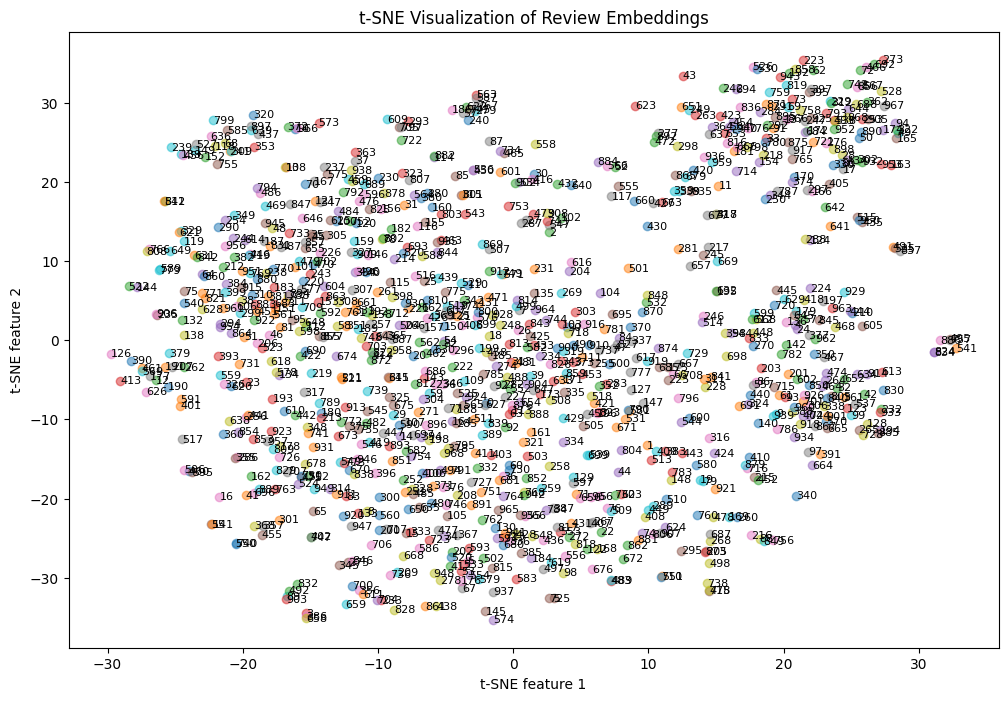

In [11]:
# Apply t-SNE for dimensionality reduction
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    return tsne.fit_transform(embeddings)

embeddings_2d = apply_tsne(np.array(embeddings))

# Plotting the results of t-SNE
def plot_tsne(tsne_results):
    plt.figure(figsize=(12, 8))
    for i, point in enumerate(tsne_results):
        plt.scatter(point[0], point[1], alpha=0.5)
        plt.text(point[0], point[1], str(i), fontsize=8, verticalalignment='center')
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

plot_tsne(embeddings_2d)

In [12]:
# Define topics
categories = ["Quality", "Fit", "Style", "Comfort"]

# Create embeddings for all categories in one API call
category_responses = client.embeddings.create(input=categories, model=EMBEDDING_MODEL).model_dump()

# Extract embeddings from the responses and map them to their respective categories
category_embeddings = [embedding["embedding"] for embedding in category_responses["data"]]
print(len(category_embeddings))

# Function to categorize feedback
def categorize_feedback(text_embedding, category_embeddings):
    similarities = [{"distance": distance.cosine(text_embedding, cat_emb), "index":i}
                     for i, cat_emb in enumerate(category_embeddings)]
    closest = min(similarities, key=lambda x: x["index"])
    return categories[closest["index"]]

# Categorize feedback
feedback_categories = [categorize_feedback(embedding, category_embeddings) for embedding in embeddings]

4


In [ ]:
# Initialize Chromadb instance for vector storage
client = chromadb.PersistentClient()

# Define vector database
review_embeddings_db = client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key),
    get_or_create=True)

# Store embeddings inside vector database
review_embeddings_db.add(
    documents=review_texts.tolist(),
    ids=[str(i) for i in range(len(review_texts))]
)

# Function for similarity search using vector db query function
def find_similar_reviews(input_text, vector_db, n=3):
    collection = client.get_collection(
        name="review_embeddings",
        embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))
    results = collection.query(
        query_texts=[input_text],
        n_results=n
    )
    return results

# Example feedback and finding similar feedback
example_review = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = find_similar_reviews(example_review, review_embeddings_db, 3)["documents"][0]
print(most_similar_reviews)